In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat
from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
Xs = torch.from_numpy(np.load('triangles/obs.npy')).float()
Mus = torch.from_numpy(np.load('triangles/mus.npy')).float()
Xs = Xs.transpose(1,2)

B, N, D = Xs.shape
## Model Parametersnum_hidden
NUM_SAMPLES = 10
NUM_HIDDEN = 32
NUM_LATENTS = 2
NUM_OBS = D
BATCH_SIZE = 100
NUM_EPOCHS = 20000
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= D,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_log_u_a = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.enc_log_u_b = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))

    def forward(self, obs, num_samples):
        h = self.enc_h(obs) # (B, H)
        a = torch.exp(self.enc_log_u_a(h)) # (B, 2)
        b = torch.exp(self.enc_log_u_b(h)) # (B, 2)
        q_u = Beta(a, b)
        u = q_u.sample((num_samples,)) # (S, B, 2)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.01 * torch.ones((N, num_obs))
        self.dec_mu = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, obs, num_samples):
        mu = self.dec_mu(u) # (S, B, K+1) -> (S, B, O)
        p_x = Normal(mu, self.x_sigma.repeat(num_samples, 1, 1)) # (S, B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (S, B)
        return mu, log_p_x

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc = Encoder()
    dec = Decoder()
#     enc.apply(weights_init)
    opt1 =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99)) 
    opt2 = torch.optim.Adam(list(dec.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    return enc, dec, opt1, opt2
enc, dec, opt1, opt2 = initialize()

In [5]:
def oneshot(x, mean, N, D, num_samples):
    data = x - mean
    X_mus = torch.zeros((num_samples, N, D))
    u, log_q = enc(data, num_samples)
    mu, log_p_x = dec(u, data, num_samples)
    pr_u = Uniform(torch.zeros(N, NUM_LATENTS), torch.ones(N, NUM_LATENTS))
    log_pr_u = pr_u.log_prob(u).sum(-1)
    log_weights = (log_pr_u + log_p_x - log_q)
    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()

    return eubo, elbo, mu, u

In [6]:
ELBOs = []
EUBOs = []
time_start = time.time()

for epoch in range(NUM_EPOCHS):
    for b in range(B):
        X = Xs[b]
        mean = Mus[b]
        indices = torch.randperm(N)
        X_shuffle = X[indices]
        opt1.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        eubo.backward()
        opt1.step()
        opt2.zero_grad()
        eubo, elbo, mu, u = oneshot(X_shuffle, mean, N, D, NUM_SAMPLES)
        (-elbo).backward()
        opt2.step()
    
        ELBOs.append(elbo.item())
        EUBOs.append(eubo.item())
    

    time_end = time.time()  
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f (%ds)' % (epoch, eubo, elbo, time_end - time_start))
    time_start = time.time()


epoch=0, EUBO=-2994.797, ELBO=-4006.702 (1s)
epoch=1, EUBO=-2583.291, ELBO=-3505.033 (1s)
epoch=2, EUBO=-2254.225, ELBO=-3194.267 (1s)
epoch=3, EUBO=-2013.209, ELBO=-2955.413 (1s)
epoch=4, EUBO=-1757.409, ELBO=-2629.562 (1s)
epoch=5, EUBO=-1524.440, ELBO=-2372.522 (1s)
epoch=6, EUBO=-1303.710, ELBO=-2134.202 (1s)
epoch=7, EUBO=-1087.320, ELBO=-1765.978 (1s)
epoch=8, EUBO=-875.609, ELBO=-1546.323 (1s)
epoch=9, EUBO=-690.367, ELBO=-1269.236 (1s)
epoch=10, EUBO=-539.567, ELBO=-1060.469 (1s)
epoch=11, EUBO=-417.669, ELBO=-852.107 (1s)
epoch=12, EUBO=-317.883, ELBO=-719.801 (1s)
epoch=13, EUBO=-256.995, ELBO=-590.650 (1s)
epoch=14, EUBO=-190.249, ELBO=-516.191 (1s)
epoch=15, EUBO=-157.554, ELBO=-464.341 (1s)
epoch=16, EUBO=-121.559, ELBO=-405.434 (1s)
epoch=17, EUBO=-95.564, ELBO=-335.698 (1s)
epoch=18, EUBO=-77.263, ELBO=-308.849 (1s)
epoch=19, EUBO=-62.006, ELBO=-263.532 (2s)
epoch=20, EUBO=-55.809, ELBO=-255.756 (5s)
epoch=21, EUBO=-47.069, ELBO=-224.283 (5s)
epoch=22, EUBO=-40.439, ELBO

KeyboardInterrupt: 

In [7]:
torch.save(enc.state_dict(), 'VAE/enc-triangle')
torch.save(dec.state_dict(), 'VAE/dec-triangle')

In [12]:
P = 8
eubo, elbo, mu, u = oneshot(Xs[P], Mus[P], N, D, NUM_SAMPLES)

In [18]:
aa = torch.FloatTensor([10, 10]).repeat(N, 1)
bb = torch.FloatTensor([0, 0])
u, log_q = enc(aa, NUM_SAMPLES)
mu, log_p_x = dec(u, aa, NUM_SAMPLES)
# pr_u = Uniform(torch.zeros(N, NUM_LATENTS), torch.ones(N, NUM_LATENTS))
# log_pr_u = pr_u.log_prob(u).sum(-1)
# log_weights = (log_pr_u + log_p_x - log_q)

In [26]:
data = Xs[P] - Mus[P]
X_mus = torch.zeros((NUM_SAMPLES, N, D))
u, log_q = enc(data, NUM_SAMPLES)
mu, log_p_x = dec(u, data, NUM_SAMPLES)

In [27]:
log_p_x

tensor([[ 7.2495,  6.9585,  5.5027,  ...,  6.3909,  5.7588,  5.7887],
        [ 6.8408,  2.0945,  7.1057,  ...,  6.6035,  4.9489,  6.9063],
        [ 4.7079,  7.3375,  2.5048,  ...,  6.5836,  5.8480,  5.6668],
        ...,
        [ 7.1227,  4.6838,  6.7379,  ...,  0.3688,  7.0337,  4.3085],
        [ 7.3124,  5.3241,  2.6684,  ..., -1.6468,  7.1827,  6.1614],
        [ 4.9916,  4.5249,  5.4222,  ...,  1.1304,  7.0892,  6.5578]],
       grad_fn=<SumBackward2>)

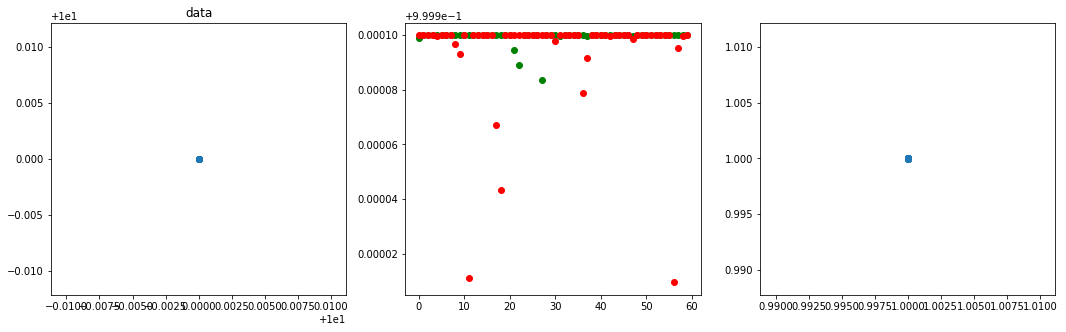

In [23]:
T = 60
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)
# ax1.scatter(Xs[P,:T, 0].data.numpy(), Xs[P, :T, 1].data.numpy())
ax1.scatter(aa[:, 0].data.numpy(), aa[:, 1].data.numpy())

# ax1.set_xlim([-4,4])
# ax1.set_ylim([-4,4])
ax1.set_title('data')

uu = u.mean(0)
ax2.plot(uu[:T, 0].data.numpy(), 'go')
ax2.plot(uu[:T, 1].data.numpy(), 'ro')

ax3.scatter(uu[:T, 0].data.numpy(), uu[:T, 1].data.numpy())
# ax3.set_xlim([-0.1,1.1])
# ax3.set_ylim([-0.1,1.1])

In [24]:
log_p_x

tensor([[-835134.2500, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.2500],
        [-835134.2500, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.2500],
        [-835134.2500, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.2500],
        ...,
        [-835136.1875, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.2500],
        [-835134.2500, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.2500],
        [-835134.2500, -835134.2500, -835134.2500,  ..., -835134.2500,
         -835134.2500, -835134.4375]], grad_fn=<SumBackward2>)

In [ ]:
u.mean(0).shape

In [ ]:
a = torch.linspace(0.0, 0.2, 100)[:, None]
angles = dec.dec_angles(a) 
rads = dec.dec_rad(a)
x_mus = angles * rads

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(x_mus[:, 0].data.numpy(), x_mus[:, 1].data.numpy())
ax1.set_xlim([-3,3])
ax1.set_ylim([-3,3])